# Partie 1 - Maison individuelle et efficacité énergétique sont-ils réconciliables ?

Derrière ce titre accrocheur cette partie s'intéresse à décrire les logements (taille, type, matérieux, etc) selon leur efficacité énergétique, c'est **l'occasion de s'initier à Python** via la manipulation et au nettoyage de bases avec `pandas` et de réaliser des premiers graphiques de visualisation avec `seaborn`. Pour ceux familier de `R` il s'agit tout simplement d'utiliser les équivalents de `dplyr`/`datatable` et `ggplot2`.

L'objectif est de savoir importer une base, décrire des variables, la transformer, filtrer des observations, regrouper et les visualiser. On peut par exemple savoir si les logements construits récemment ont une meilleure efficacité énergétique, ou s'il vaut mieux vivre en appartement. Il s'agit bien sûr d'un exercice pour s'entraîner plutôt qu'un jugement de politique publique. Ici se ne sont que de simples statistiques descriptives, les maisons sont peut-être en proportion plus efficaces... parce que plus rénovées ! Et donc à la base moins efficaces...!

On peut se donner comme objectif final le plot suivant, mais il existe pleins d'autres analyses intéressantes... et on peut les valoriser autrement qu'avec un notebook ! `Streamlit` offre un équivalent à `Rshiny` pour faire une application interactive.

Pour d'autres idées de graphiques et une illustration de **l'utilité de ces techniques pour nos métiers de tous les jours**, la publication du SDES que l'on peut chercher à reproduire : https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-09/document_travail_49_parc_logements_consommation_energie_septembre2020.pdf

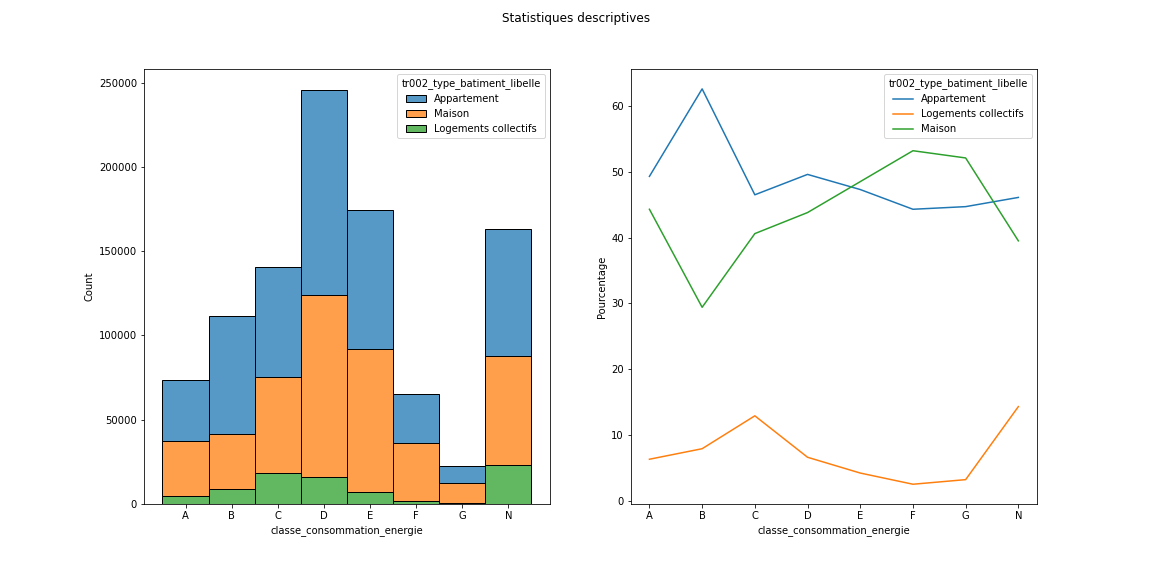

## 1. Importation des packages et des données

In [1]:
import os
import s3fs # Pour accéder au système de stockage des données de Minio
import pandas as pd # Pour manipuler des bases de données
import seaborn as sns # Pour faire de belles visualisation
import matplotlib.pyplot as plt # Utile aussi pour mettre en forme un peu plus les visualisations précédentes

In [2]:
# Afficher toutes les colonnes quand on veut regarder les bases de données
pd.set_option('display.max_columns', None)

Pour importer des données depuis Minio il faut se référer à https://docs.sspcloud.fr/onyxia-guide/stockage-de-donnees

Si les données étaient en local il suffirait de faire le `pd.read_csv()` sans passer par ces fonctions issues du package s3fs. Ici on va chercher les données crées en Partie 0 et qui ont été stockées sur Minio (espace de stockage du Datalab).

In [3]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
BUCKET = "projet-funathon/diffusion/2022/Sujet 3 - DPE"
FILE_KEY_S3 = "dpe_ademe_light.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    df_source = pd.read_csv(file_in, sep=",", dtype={'code_postal': str, 'code_insee_commune': str, 'code_insee_commune_actualise': str, 
                                                     'numero_lot':str, 'partie_batiment': str, 'type_vitrage_verriere': str})

On peut trouver des informations sur les données ici : https://data.ademe.fr/datasets/dpe-france dans la partie description des champs, on tombe alors sur l'image suivante. **Il y a un également un pdf plus exhaustif à la racine du dossier Sujet 3 ainsi que dans le dossier dpe/notebooks.**


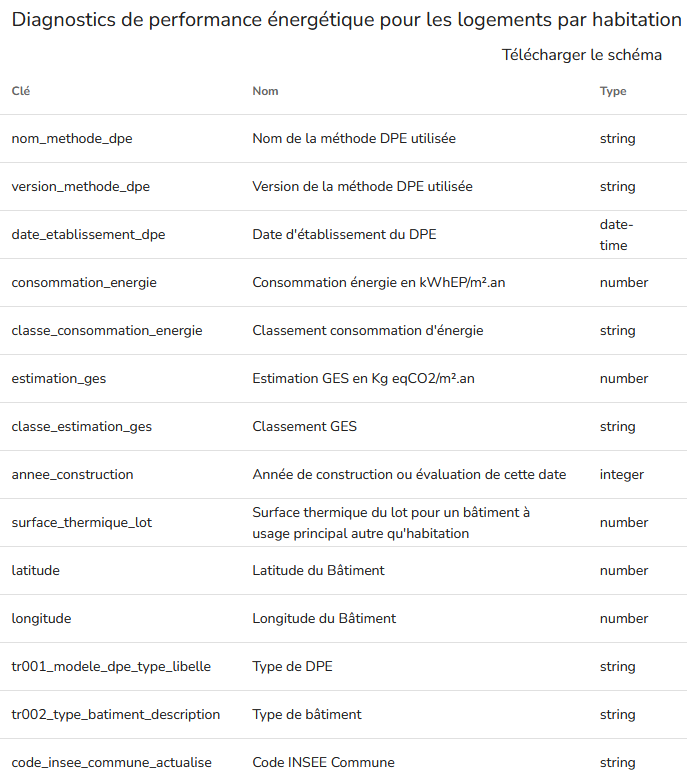. 

Petit rappel des différences et définition DPE, GES, etc: en résumé : "Attention, il ne faut pas confondre la classe GES et le Diagnostic de Performance Energétique (DPE), qui sont différents. Le classe GES est une partie du DPE, mais le DPE ne s’arrête pas au calcul du GES. Le Diagnostic de Performance Énergétique d’un logement tient aussi compte de la nature des énergies utilisées (fossiles, électricité, ou renouvelable)" si on veut plus d'infos il y en a ici : https://monexpert-renovation-energie.fr/renovation-energetique/quest-ce-que-la-classe-ges-comment-est-elle-calculee

Plus d'informations également dans les slides du SDES à la racine du dossier.

## 2. Quelques rapides dénombrements, vérifications et nettoyages

### 2.1 Fonctions de bases de pandas

Des premières fonctions issues de pandas toujours utiles pour une première exploration de la base

In [5]:
# Si on ne spécifie pas l'argument dans head cela montre automatiquement les 5 premières lignes de la base...
df_source.head()

id     numero_dpe  usr_diagnostiqueur_id  usr_logiciel_id  \
0  4148118  1675V2018598K                   3172                3   
1  6553120  1815V1000472N                  12629                2   
2  1515164  1489V1001334S                   7159                3   
3  9554463  2094V1000990S                  21058                2   
4  1765182  1551L1000045F                   9363                5   

   tr001_modele_dpe_id  nom_methode_dpe   version_methode_dpe  \
0                    2  Méthode Facture                   NaN   
1                    1        3CL - DPE                 V2012   
2                    1      Méthode 3CL  3CL-DPE, version 1.3   
3                    1        3CL - DPE                 V2012   
4                    9     TROIS_CL_DPE          VERSION_2012   

  nom_methode_etude_thermique version_methode_etude_thermique  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

  date_visite_diagnostiqueur date_etablissement_dpe  \
0                 2016-12-07             2016-12-08   
1                 2018-07-19             2018-07-19   
2                 2014-11-06             2014-11-07   
3                 2020-03-10             2020-05-18   
4                 2015-01-30             2015-01-30   

  date_arrete_tarifs_energies  \
0                  2015-09-15   
1                  2015-08-15   
2                  2011-09-15   
3                  2015-08-15   
4                  2011-08-15   

          commentaires_ameliorations_recommandations  \
0                                                NaN   
1  La surface habitable mentionnée dans le présen...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

  explication_personnalisee  consommation_energie classe_consommation_energie  \
0                       NaN                263.00                           E   
1                        17                157.13                           D   
2                       NaN                404.00                           F   
3                        17                302.45                           E   
4                       NaN                394.00                           F   

   estimation_ges classe_estimation_ges  tr002_type_batiment_id  \
0           61.00                     F                       2   
1           36.77                     E                       1   
2           23.00                     D                       1   
3           90.46                     G                       1   
4           92.19                     G                       2   

                     secteur_activite  tr012_categorie_erp_id  \
0                                 NaN                     NaN   
1  Habitation (Maisons individuelles)                     NaN   
2                                 NaN                     NaN   
3                                 NaN                     NaN   
4                                 NaN                     NaN   

   tr013_type_erp_id  annee_construction  surface_habitable  \
0                NaN                   1              44.00   
1                NaN                2005              91.02   
2                NaN                1978              74.00   
3                NaN                1949             200.00   
4                NaN                1974              76.76   

   surface_thermique_lot  tv016_departement_id            commune  \
0                  44.00                    75              PARIS   
1                  91.02                    15              MAURS   
2                  74.00                    89            AUXERRE   
3       

In [6]:
# ...et ici les 3 dernières !
df_source.tail(3)

id     numero_dpe  usr_diagnostiqueur_id  usr_logiciel_id  \
996246  7940074  1958V2000802T                  17875                3   
996247  7764491  1914N1000968P                  19096               10   
996248  9986656  2057V2002275Q                  13204               16   

        tr001_modele_dpe_id  nom_methode_dpe version_methode_dpe  \
996246                    2  Méthode Facture                 NaN   
996247                   11    FACTURE - DPE               V2012   
996248                    2            th-CE               V2005   

       nom_methode_etude_thermique version_methode_etude_thermique  \
996246                         NaN                             NaN   
996247                 Th-BCE 2012                            7501   
996248                         NaN                             NaN   

       date_visite_diagnostiqueur date_etablissement_dpe  \
996246                 2019-05-13             2019-05-13   
996247                 2019-03-05             2019-03-05   
996248                 2020-08-12             2020-08-12   

       date_arrete_tarifs_energies  \
996246                  2015-09-15   
996247                  2015-08-15   
996248                  2015-08-15   

               commentaires_ameliorations_recommandations  \
996246  Pour ce type d'immeuble, la réglementation imp...   
996247   Veuillez au bon entretien des bouches de vent...   
996248                                                NaN   

                                explication_personnalisee  \
996246  Des écarts peuvent apparaître entre les consom...   
996247                                                NaN   
996248                                                NaN   

        consommation_energie classe_consommation_energie  estimation_ges  \
996246                 86.00                           B           26.00   
996247                 55.26                           B           12.93   
996248                230.29                           D           33.32   

       classe_estimation_ges  tr002_type_batiment_id secteur_activite  \
996246                     D                       1              NaN   
996247                     C                       2              NaN   
996248                     D                       1              NaN   

        tr012_categorie_erp_id  tr013_type_erp_id  annee_construction  \
996246                     NaN                NaN                1947   
996247                     NaN                NaN                2019   
996248                     NaN                NaN                1947   

        surface_habitable  surface_thermique_lot  tv016_departement_id  \
996246             122.51                 122.51                    58   
996247              47.00                  47.00                    14   
996248             120.00                 120.00                    57   

                    commune arrondissement type_voie  \
996246                 BONA            NaN       NaN   
996247  COURSEULLES-SUR-MER            0.0       NaN   
996248           THIONVILLE            NaN       NaN   

                          nom_rue numero_rue batiment escalier etage porte  \
996246   RUE DE L'EGLISE LE BOURG        NaN      NaN      NaN   NaN   NaN   
996247  Royal Square - Quai Ouest        NaN      NaN      NaN   NaN   NaN   
996248           9 Rue Saint Jean        NaN      NaN      NaN   NaN   NaN   

       code_postal code_insee_commune code_insee_commune_actualise  \
996246     58330.0            58035.0                      58035.0   
996247       14470              14191                        14191   
996248     57100.0            57672.0                      57672.0   

        numero_lot quote_part  nom_centre_commercial  \
996246  Sans objet        NaN                    NaN   
996247         NaN        NaN                    NaN   
996248         NaN        NaN                    NaN   

        surface_commerciale_contractuelle  por

In [7]:
df_source.info()
# Il y a beaucoup de colonnes mais quand il y en a peu plus d'informations s'affichent, on peut forcer l'affichage avec:
# df.info(verbose = True)
# Liste de variables accessibles ici aussi :
# list(df_source.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996249 entries, 0 to 996248
Columns: 131 entries, id to tv018_zone_ete_rclim_dernier_etage
dtypes: float64(48), int64(27), object(56)
memory usage: 995.7+ MB


In [9]:
# Donnes des informations sur les distributions des variables continues
df_source.describe()

id  usr_diagnostiqueur_id  usr_logiciel_id  \
count  9.962490e+05          996249.000000    996249.000000   
mean   5.485939e+06           11151.562611         5.609430   
std    3.145285e+06            5696.717011         3.804071   
min    5.400000e+01               1.000000         2.000000   
25%    2.755715e+06            6908.000000         3.000000   
50%    5.506443e+06           11568.000000         3.000000   
75%    8.216579e+06           15267.000000        10.000000   
max    1.088838e+07           24530.000000        16.000000   

       tr001_modele_dpe_id  consommation_energie  estimation_ges  \
count        996249.000000          9.962490e+05   996249.000000   
mean              5.325194          1.798694e+02       24.562051   
std               4.604155          2.989591e+03      659.867506   
min               1.000000         -3.429172e+04    -8024.260000   
25%               1.000000          5.866000e+01        5.000000   
50%               2.000000          1.561000e+02       13.550000   
75%              10.000000          2.390000e+02       33.000000   
max              23.000000          2.532281e+06   592553.680000   

       tr002_type_batiment_id  tr012_categorie_erp_id  tr013_type_erp_id  \
count           996249.000000             8711.000000       44899.000000   
mean                 1.654834                1.236597          22.615092   
std                  0.623901                0.932225           2.730407   
min                  1.000000                1.000000           1.000000   
25%                  1.000000                1.000000          23.000000   
50%                  2.000000                1.000000          23.000000   
75%                  2.000000                1.000000          23.000000   
max                  3.000000                5.000000          30.000000   

       annee_construction  surface_habitable  surface_thermique_lot  \
count       996249.000000       9.962110e+05           9.962110e+05   
mean          1898.005150       2.305919e+02           2.305919e+02   
std            404.255384       1.001929e+05           1.001929e+05   
min             -1.000000      -1.360000e+02          -1.360000e+02   
25%           1947.000000       5.060000e+01           5.060000e+01   
50%           1974.000000       7.334000e+01           7.334000e+01   
75%           2001.000000       1.013600e+02           1.013600e+02   
max          32767.000000       1.000000e+08           1.000000e+08   

       tv016_departement_id  nom_centre_commercial  \
count         996249.000000                    0.0   
mean              52.787173                    NaN   
std               26.658787                    NaN   
min                1.000000                    NaN   
25%               31.000000                    NaN   
50%               57.000000                    NaN   
75%               75.000000                    NaN   
max               97.000000                    NaN   

       surface_commerciale_contractuelle  portee_dpe_batiment           shon  \
count                      104363.000000        795845.000000  756142.000000   
mean                            0.851748             0.241709      18.974344   
std                             9.189250             0.542372     406.923431   
min                             0.000000             0.000000       0.000000   
25%                             0.000000             0.000000       0.000000   
50%                             0.000000             0.000000       0.000000   
75%                             0.000000             0.000000       0.000000   
max                           100.000000             2.000000   33184.000000   

       surface_utile  surface_thermique_parties_communes  en_souterrain  \
count  795877.000000                       795845.000000  756137.000000   
mean       12.702879                            0.002237       0.000001   
std       270.877127                            0.720855       0.001150   
min

### 2.2 Regarder quelques variables d'intérêt avant de se lancer dans l'analyse

Une bonne idée pour s'assurer de la qualité de la base est de regarder plus spécifiquement certaines variables - celles qui nous intéressent - et de s'assurer que tout fonctionne, à défaut de comprendre les traitements à réaliser en amont.

In [10]:
true_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'N']

In [11]:
df_source['classe_consommation_energie'].unique()

array(['E', 'D', 'F', 'B', 'N', 'C', 'A', 'G', 'S', '-', '4', 'I', '5',
       'H'], dtype=object)

La variable d'intérêt n'est pas propre, ça commence mal... Faisons des décomptes et caractérisons les logements avec des problèmes

In [12]:
# Fonction pandas à trouver par vous même ! Ou en cliquant sur les ...

In [13]:
df_source['classe_consommation_energie'].value_counts()

D    245897
E    174201
N    163240
C    140619
B    111474
A     73322
F     64987
G     22437
S        57
I         8
5         3
4         2
-         1
H         1
Name: classe_consommation_energie, dtype: int64

Qui sont les logements avec des catégories 'I' par exemple ? Sont-ils nombreux ? Peut-on les supprimer sans risque ? C'est l'occasion de s'entraîner à sélectionner certaines observations sur la base de conditions.

In [15]:
# CODE : Utiliser les fonctions pandas pour ne sélectionner que les 8 observations anormales avec "I" comme catégorie DPE

In [16]:
df_dpe_catI = df_source[df_source['classe_consommation_energie'] == 'I']

In [17]:
#Nombre d'observations ayant I
df_dpe_catI.shape[0]

8

72 observations problématiques en tout dont 8 catégories "I"

### 2.3 Quelques corrections à apporter

Par précaution mieux vaut filtrer ces observations problématiques

On duplique les données juste au cas où on fasse une erreur de manipulation il suffit de recharger cette ligne au lieu de tout reprendre depuis Minio (si les données sont lourdes ça prend du temps !).
Par ailleurs il y a avec pandas un système de "chaînes" entre les bases de données, si on mettait df = df_source et qu'on modifiait dans une autre ligne df_source alors df serait modifié, dans ce cas c'est simple mais quand on enchaîne beaucoup d'instruction on peut perdre le fil des chaînes et ses conséquences...

In [18]:
df = df_source.copy()

#### -> Classe_consommation_energie

In [19]:
# Données triées par classe de conso énergétique uniquement à des fins de plot par catégorie dans l'ordre alphabétique et pour mieux visualiser les données problématiques 
# avec des .head() et .tail(), il y a tout à fait moyen de faire différemment en passant une option sur les x au moment des plots
df = df.sort_values('classe_consommation_energie')

On peut restreindre la base df aux bonnes observations (indices, regardez du côté des fonctions/méthodes de pandas : `.loc` et `.isin`
Pour rappel les catégories attendues sont `true_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'N']`

In [20]:
df = df.loc[df['classe_consommation_energie'].isin(true_categories)]

In [21]:
len(df_source) - len(df)

72

On a bien éliminé les 72 observations problématiques !

In [22]:
# Plusieurs lignes correspondent à la même adresse, peut-être des visites à différentes dates d'un même contrôleur ou à l'inverse de plusieurs entités contrôleuses ou c'est normal !
# On peut garder de manière arbitraire la première qui apparaît dans la liste
# data_sort = data_sort.drop_duplicates(subset='geo_adresse', 
#                          keep='first', 
#                          inplace=False, 
#                          ignore_index=False)

In [23]:
categories = df['classe_consommation_energie'].unique()

In [24]:
categories

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'N'], dtype=object)

Ouf tout va bien il ne reste plus que les bonnes catégories (on aurait d'ailleurs pu faire le choix de ne pas garder les observations "N")

#### -> Surface habitable, testons si cette variable est bien renseignée

<AxesSubplot:>

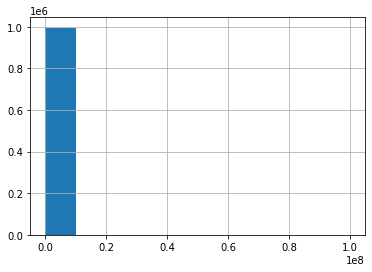

In [26]:
#_ = sns.histplot(data = df, x = 'surface_habitable')
df['surface_habitable'].hist()

Visiblement il y a quelques valeurs extrêmes voire des erreurs : 10^8 m² ça commence à faire beaucoup, regardons de plus près

In [27]:
#ça c'est la médiane
df['surface_habitable'].quantile()

73.34

In [28]:
#Et là un peu plus de détails
df['surface_habitable'].quantile([0,0.01,0.1,0.5,0.9,0.99,0.999,1])

0.000        -136.00
0.010          15.82
0.100          33.00
0.500          73.34
0.900         145.00
0.990        1672.00
0.999        6666.00
1.000    99999999.99
Name: surface_habitable, dtype: float64

Supprimons arbitrairement les surfaces au dessus de 10 000m²

In [29]:
df[df['surface_habitable'] > 10000]

id     numero_dpe  usr_diagnostiqueur_id  usr_logiciel_id  \
709491   6584292  1869L2004276C                  11838               16   
844777   6584285  1869L2004271X                  11838               16   
341299   6584226  1869L2004231T                  11838               16   
20942    6584027  1869L2004089E                  11838               16   
597703   6584186  1869L2004202R                  11838               16   
...          ...            ...                    ...              ...   
740561   9969624  2023V2000591I                    661                5   
319687   1017220  1450V2001097N                   2809                3   
80494    9509846  2067V2001251K                  14179                3   
610709  10548468  1875N1003840N                  17943                3   
331481   2463069  1588V2000696D                  12389                9   

        tr001_modele_dpe_id  nom_methode_dpe version_methode_dpe  \
709491                   10            th-CE               V2005   
844777                   10            th-CE               V2005   
341299                   10            th-CE               V2005   
20942                    10            th-CE               V2005   
597703                   10            th-CE               V2005   
...                     ...              ...                 ...   
740561                    2          FACTURE        VERSION_2012   
319687                    2  Méthode Facture                 NaN   
80494                     2  Méthode Facture                 NaN   
610709                   11  Méthode Facture                 NaN   
331481                    2          Facture                v15c   

       nom_methode_etude_thermique version_methode_etude_thermique  \
709491                         NaN                             NaN   
844777                         NaN                             NaN   
341299                         NaN                             NaN   
20942                          NaN                             NaN   
597703                         NaN                             NaN   
...                            ...                             ...   
740561                         NaN                             NaN   
319687                         NaN                             NaN   
80494                          NaN                             NaN   
610709                         NaN                             NaN   
331481                         NaN                             NaN   

       date_visite_diagnostiqueur date_etablissement_dpe  \
709491                 2018-07-23             2018-07-23   
844777                 2018-07-23             2018-07-23   
341299                 2018-07-23             2018-07-23   
20942                  2018-07-23             2018-07-23   
597703                 2018-07-23             2018-07-23   
...                           ...                    ...   
740561                 2020-08-07             2020-08-07   
319687                 2014-05-23             2014-05-30   
80494                  2020-02-20             2020-02-20   
610709                 2018-09-21             2018-11-14   
331481                 2015-08-25             2015-08-25   

       date_arrete_tarifs_energies commentaires_ameliorations_recommandations  \
709491                  2015-08-15                                        NaN   
844777                  2015-08-15                                        NaN   
341299                  2015-08-15                                        NaN   
20942                   2015-08-15                                        NaN   
597703                  2015-08-15                                        NaN   
...                            ...                                        ...   
740561                  2011-08-15                                        NaN   
319687                  2011-09-15                                        NaN   
80494

In [30]:
df = df[df['surface_habitable'] < 10000]

<AxesSubplot:>

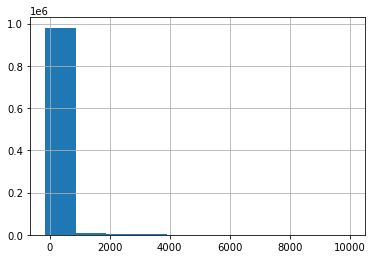

In [31]:
df['surface_habitable'].hist()

Un peu mieux, de fait on a contraint la taille en m² maximale, essayons de zoomer pour mieux voir ce qu'il se passe !

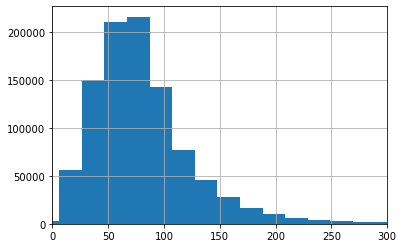

In [32]:
df['surface_habitable'].hist(bins = 500)
_ = plt.xlim([0,300])

### 2.4 Libre à vous de réutiliser les fonctions précédentes pour investiguer d'autres variables et faire les traitements jugés nécessaires

Pour un rappel des variables disponibles il faut décommenter la fonction suivante :

In [33]:
#list(df.columns)

## 3. Premiers plots simples à partir de seaborn

On utilise seaborn (importé généralement sous le nom de sns) pour faire des plots descriptifs, le "_ = sns." au début de ligne permet d'avoir le plot sans voir l'appel à la méthode qui donnerait avant le graphique quelque chose comme "<seaborn.axisgrid.FacetGrid at 0x7f0d56f8afd0>"

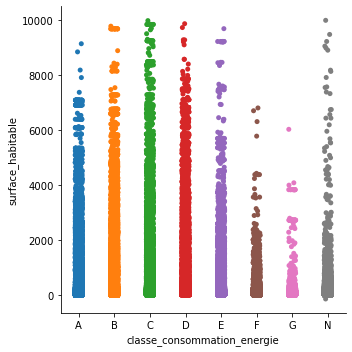

In [34]:
_ = sns.catplot(data = df,
               x = 'classe_consommation_energie', 
               y = 'surface_habitable',
               order = categories)

Dans une analyse rigoureuse menant à publication il faudrait peut-être supprimer la modalité "logements collectifs" dans les types de logements : elle est très peu présente et correspond au cas d'un DPE réalisé pour un immeuble dans sa globalité;

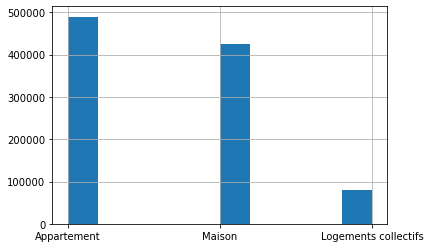

In [36]:
_ = df['tr002_type_batiment_libelle'].hist()

Les dataframes pandas disposent en propre d'une méthode de plot hist() - il y en a d'autres - on aurait aussi pu utiliser seaborn pour un résultat similaire mais qui permet plus de flexibilité et de modulation esthétique :

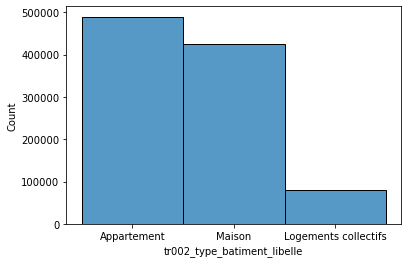

In [37]:
_ = sns.histplot(x = 'tr002_type_batiment_libelle', data = df)

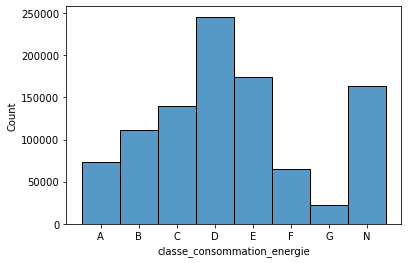

In [38]:
_ = sns.histplot(x = 'classe_consommation_energie', data = df)

## 4. Un cran plus loin dans `seaborn` en regardant les différences selon les caractéristiques d'intérêt

On peut différencier les plots selon les catégories grâce au paramètre `hue`, pour voir l'ensemble des paramètres il existe le raccourci de cliquer sur une fonction et de faire maj+tab pour ouvrir le helper

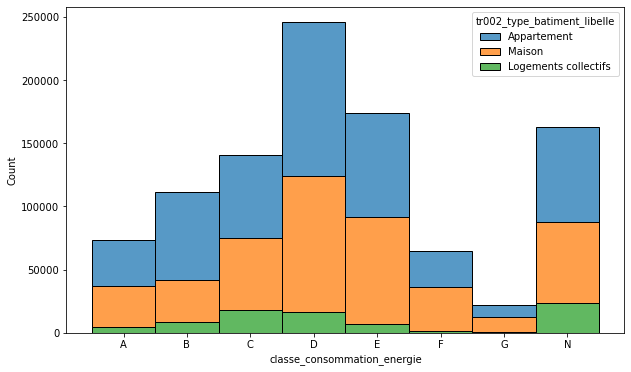

In [39]:
plt.figure(figsize=(10, 6))
_ = sns.histplot(x = 'classe_consommation_energie', hue = 'tr002_type_batiment_libelle', multiple = 'stack', data = df)

Une proposition : représenter ces graphiques non pas en chiffres absolus mais en pourcentage, pour cela il va falloir utiliser groupby ! La solution en cliquant sur les trois petits points

In [40]:
# Votre code ici

In [41]:
calcul = df[['id', 'classe_consommation_energie', 'tr002_type_batiment_libelle']].groupby(by = ['classe_consommation_energie', 'tr002_type_batiment_libelle'], as_index=False).count()

In [42]:
calcul['Pourcentage'] = round(100*calcul['id'] / calcul.groupby('classe_consommation_energie')['id'].transform('sum'),1)

In [43]:
calcul

classe_consommation_energie tr002_type_batiment_libelle      id  \
0                            A                 Appartement   36183   
1                            A        Logements collectifs    4642   
2                            A                      Maison   32495   
3                            B                 Appartement   69785   
4                            B        Logements collectifs    8834   
5                            B                      Maison   32814   
6                            C                 Appartement   65268   
7                            C        Logements collectifs   18190   
8                            C                      Maison   57009   
9                            D                 Appartement  121971   
10                           D        Logements collectifs   16155   
11                           D                      Maison  107570   
12                           E                 Appartement   82403   
13                           E        Logements collectifs    7266   
14                           E                      Maison   84490   
15                           F                 Appartement   28794   
16                           F        Logements collectifs    1605   
17                           F                      Maison   34587   
18                           G                 Appartement   10036   
19                           G        Logements collectifs     709   
20                           G                      Maison   11689   
21                           N                 Appartement   75298   
22                           N        Logements collectifs   23420   
23                           N                      Maison   64499   

    Pourcentage  
0          49.3  
1           6.3  
2          44.3  
3          62.6  
4           7.9  
5          29.4  
6          46.5  
7          12.9  
8          40.6  
9          49.6  
10          6.6  
11         43.8  
12         47.3  
13          4.2  
14         48.5  
15         44.3  
16          2.5  
17         53.2  
18         44.7  
19          3.2  
20         52.1  
21         46.1  
22         14.3  
23         39.5

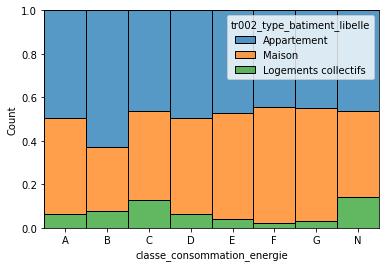

In [44]:
_ = sns.histplot(x = 'classe_consommation_energie', hue = 'tr002_type_batiment_libelle', multiple = 'fill', data = df)

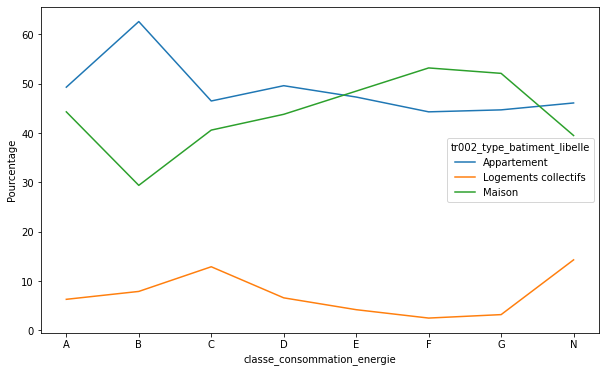

In [45]:
plt.figure(figsize=(10, 6))
_ = sns.lineplot(x = 'classe_consommation_energie', y = 'Pourcentage', hue = 'tr002_type_batiment_libelle', data = calcul)

Et pour mettre tous ces beaux graphiques ensemble on peut utiliser les subplots, un tour sur Stack Overflow pour trouver de l'aide ou sinon toujours la solution disponible.

<AxesSubplot:xlabel='classe_consommation_energie', ylabel='Pourcentage'>

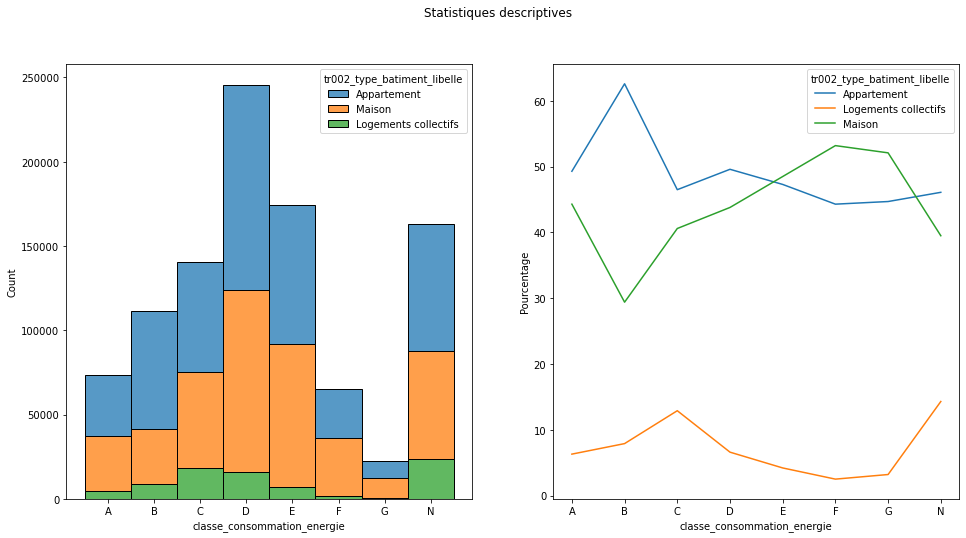

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('Statistiques descriptives')

sns.histplot(ax=axes[0], x = 'classe_consommation_energie', hue = 'tr002_type_batiment_libelle', multiple = 'stack', data = df)
#axes[0].legend(title = 'Bronjour')
sns.lineplot(ax=axes[1], x = 'classe_consommation_energie', y = 'Pourcentage', hue = 'tr002_type_batiment_libelle', data = calcul)
#plt.savefig('exemple_resultat.png')

## 5. D'autres variables possibles : date de construction, surface au sol, etc... en manipulant un peu plus la base :)

Dans la publication du SDES https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-09/document_travail_49_parc_logements_consommation_energie_septembre2020.pdf on a par exemple le graphique suivant, le code réalisé dans ce notebook en propose d'autres, pour vous exercer vous pouvez par vous même chercher à reproduire *stricto sinsu* les mêmes graphiques ce qui est un bon entraînement aux options graphiques de `seaborn`

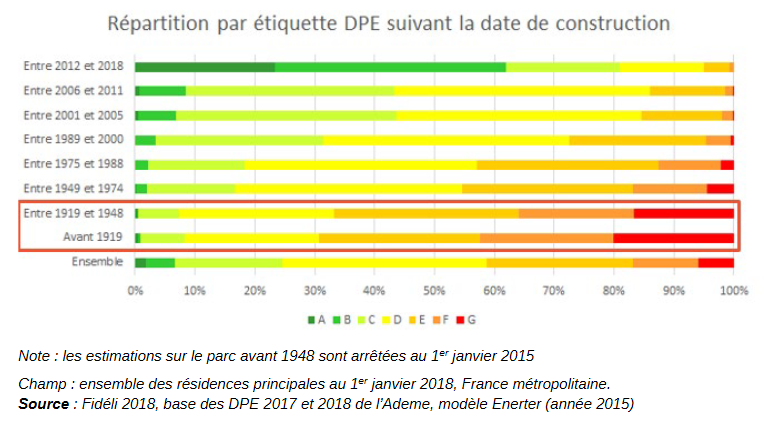

In [47]:
bins_annee = [0,1699, 1899, 1949, 1969, 1979, 1999, 2009, 2022, 10000]
label_annee =['Inconnu', 'Ancienne', 'Début XX', 'Années 50 et 60','Années 70', 'Années 80 et 90', 'Années 2000', 'Années 2010', 'Inconnu2']

In [48]:
bins_annee = [0,1699, 1899, 1949, 1979, 1999, 2009, 2015, 2022, 10000]
label_annee =['Inconnu', 'Ancienne', 'Début XX', 'Années 50, 60 et 70', 'Années 80 et 90', 'Années 2000', 'Début 2010', '2016 à de nos jours', 'Inconnu2']

In [49]:
df['annee_constr_cat'] = pd.cut(df['annee_construction'], bins=bins_annee, labels=label_annee)

In [50]:
df['annee_constr_cat'] = df['annee_constr_cat'].replace(['Ancienne', 'Inconnu2'], 'Inconnu')

In [51]:
#data_sort['annee_constr_cat'] = pd.cut(data['annee_construction'],bins=[0,1970, 2000, 10000],labels=['Ancienne', 'Années 1970 à 2000', 'Années 2000 et après'])

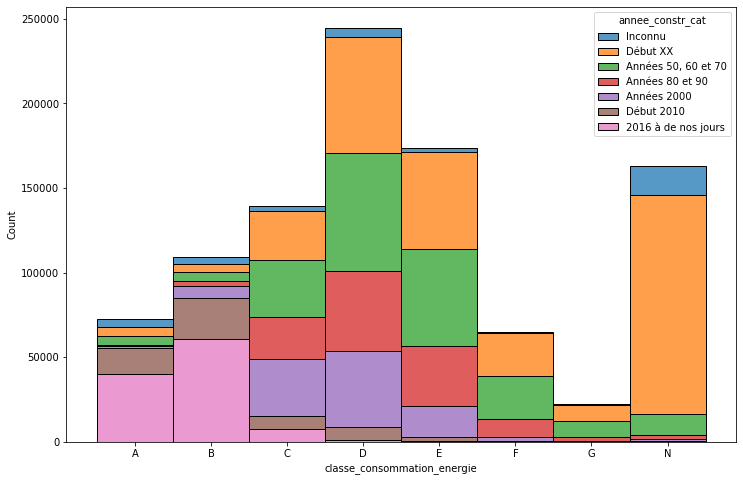

In [52]:
plt.figure(figsize=(12, 8))
_ = sns.histplot(x = 'classe_consommation_energie', hue = 'annee_constr_cat', multiple='stack', data = df)

Il y a aussi des soucis avec la variable surface habitable, mieux vaut les corriger !

In [53]:
df['surface_habitable'].describe()

count    995712.000000
mean        122.232944
std         375.051195
min        -136.000000
25%          50.600000
50%          73.300000
75%         101.260000
max        9999.000000
Name: surface_habitable, dtype: float64

In [54]:
bins_surface = [0, 50, 80, 110, 200, 10000]
label_surface =['Moins de 50', '50 à 80', '80 à 110','110 à 200', '> 200']

In [55]:
df['surface_habitable_cat'] = pd.cut(df['surface_habitable'], bins = bins_surface, labels = label_surface)

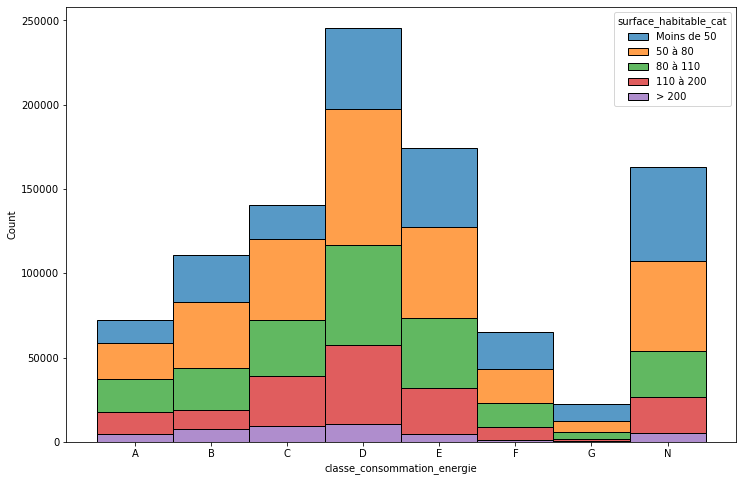

In [56]:
plt.figure(figsize=(12, 8))
_ = sns.histplot(x = 'classe_consommation_energie', hue = 'surface_habitable_cat', multiple='stack', data = df)

In [57]:
calcul = df[['id', 'classe_consommation_energie', 'surface_habitable_cat']].groupby(by = ['classe_consommation_energie', 'surface_habitable_cat'], as_index=False).count()
calcul['percent'] = round(100*calcul['id'] / calcul.groupby('classe_consommation_energie')['id'].transform('sum'),1)

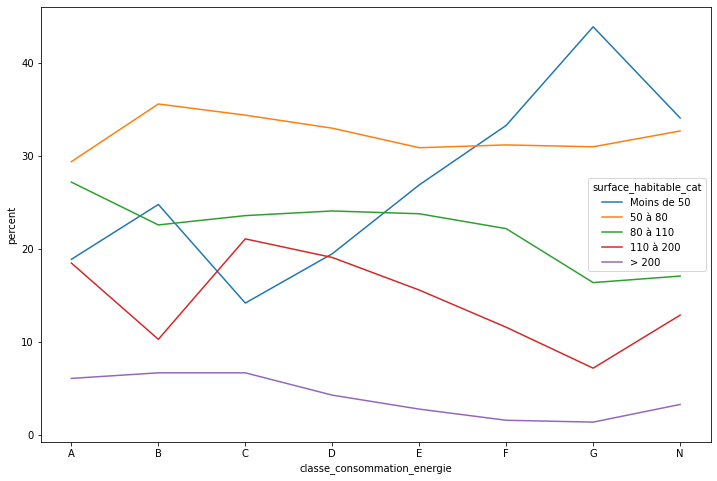

In [58]:
plt.figure(figsize=(12, 8))
_ = sns.lineplot(x = 'classe_consommation_energie', y="percent", hue = 'surface_habitable_cat', data = calcul)

**Et il reste encore beaucoup d'autres variables exploitables (`surface_parois_verticales_opaques_deperditives bonjour`), have fun(athon) !**